In [79]:
import pandas as pd
import spacy
import steamreviews
import json
import csv
import os
import glob
import json
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt

## Reviews download
https://pypi.org/project/steamreviews/

In [80]:
dir_name = "data"
reviews_jsons = glob.glob(f"{dir_name}/*")
reviews_jsons

['data\\review_1150690.json',
 'data\\review_1172620.json',
 'data\\review_1341290.json',
 'data\\review_1515210.json',
 'data\\review_210970.json',
 'data\\review_219150.json',
 'data\\review_219890.json',
 'data\\review_250320.json',
 'data\\review_257510.json',
 'data\\review_262060.json',
 'data\\review_289070.json',
 'data\\review_294100.json',
 'data\\review_304430.json',
 'data\\review_394360.json',
 'data\\review_400.json',
 'data\\review_427520.json',
 'data\\review_460950.json',
 'data\\review_550.json',
 'data\\review_620.json',
 'data\\review_632470.json',
 'data\\review_646570.json',
 'data\\review_736260.json',
 'data\\review_860510.json']

In [81]:
title_dict = {"219150": "Hotline Miami",
              "1172620" : "Sea of Thieves",
              "460950" : "Katana ZERO",
              "262060" : "Darkest Dungeon",
              "250320" : "The Wolf Among Us",
              "210970" : "The Witness",
              "620" : "Portal 2",
              "736260" : "Baba Is You",
              "219890" : "Antichamber",
              "289070" : "Sid Meier's Civilization VI",
              "427520" : "Factorio",
              "257510" : "The Talos Principle",
             "304430" : "INSIDE",
             "400" : "Portal",
             "394360" : "Hearts of Iron IV",
             "632470" : "Disco Elysium",
             "294100" : "RimWorld",
              "646570" : "Slay the Spire",
              "1150690" : "Omori",
              "1341290" : "We Were Here Forever",
              "1515210" : "The Past Within",
              "860510" : "Little Nightmares II",
              "550" : "Left 4 Dead 2"}

In [82]:
genre_dict = {"219150": "A",
              "1172620" : "A",
              "460950" : "A",
              "262060" : "R",
              "250320" : "R",
              "210970" : "P",
              "620" : "P",
              "736260" : "P",
              "219890" : "P",
              "289070" : "S",
              "427520" : "S",
              "257510" : "P",
              "304430" : "P",
             "400" : "P",
             "394360" : "S",
             "632470" : "R",
             "294100" : "S",
             "646570" : "R",
             "1150690" : "R",
             "1341290" : "P",
             "1515210" : "P",
             "860510" : "P",
             "550" : "A"}

In [83]:
data_list = []
for i in reviews_jsons:
    with open(i, encoding = "utf-8") as json_file:
        json_data = json.load(json_file)
        reviews = json_data['reviews']
        file_name = json_file.name.split('.')[0].split('_')[1]
        for key in reviews.keys():
            data_list.append([title_dict.get(file_name),genre_dict.get(file_name),reviews[key]['author']['steamid'], reviews[key]['votes_up'], 
                          reviews[key]['review'], reviews[key]['weighted_vote_score'],  
                          reviews[key]['author']['num_games_owned'], reviews[key]['author']['playtime_at_review'],
                          reviews[key]['author']['num_reviews'], 
                          reviews[key]["timestamp_created"] ])
df = pd.DataFrame(data_list, columns = ["title", "genre","steamid", "votes_up", "review", "weighted_vote_score", 
                                        "num_games_owned", "playtime_at_review", "num_reviews", "timestamp_created"])

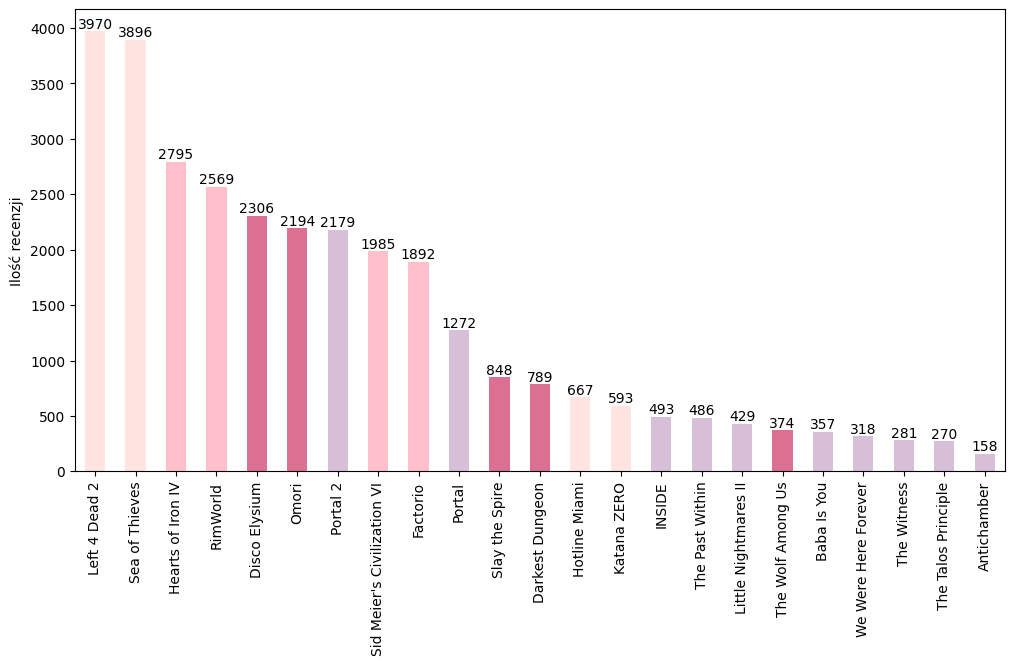

In [84]:
value_counts_title = df["title"].value_counts()
genre_colors = {"A": "mistyrose", "R": "palevioletred", "P": "thistle", "S": "pink"}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_title.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_title):
    x.text(i, count, count, va = "bottom", ha = "center")

plt.show()

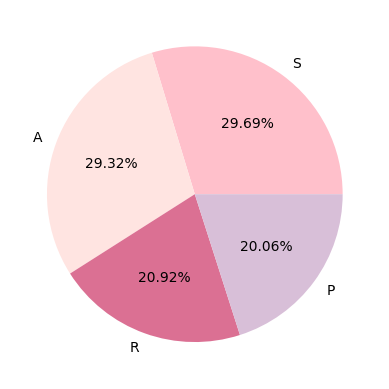

In [85]:
value_counts_genre = df["genre"].value_counts()
colors = ["pink", "mistyrose", "palevioletred", "thistle"]
x = plt.pie(value_counts_genre, labels = value_counts_genre.index, colors=colors, autopct='%1.2f%%')
plt.show()

In [86]:
df.sample(frac=0.3).head()

,title,genre,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color
17241,Hearts of Iron IV,S,76561198105401014,174,i love staring at maps for hours upon hours wa...,0.911403834819793701,247,18007,5,1634362659,pink
17594,Portal,P,76561198315274252,1,Quick but a golden oldie! I only recently play...,0.523809552192687988,108,184,70,1691360342,thistle
18539,Portal,P,76561198270711812,45,Good Puzzle game. Requires creative thinking,0.804536819458007813,189,140,6,1511380149,thistle
23237,Left 4 Dead 2,A,76561199211633618,1,Zombies and Divan ot vsichko nai-dobroto,0.523809552192687988,0,226,5,1672669020,mistyrose
7292,Hotline Miami,A,76561198051095318,5,mindlessly kill commies simulator,0.563139915466308594,156,908,26,1695398732,mistyrose


## Preprocessing

1. Braki danych
2. Sprawdzenie duplikatów
3. Usunięcie recenzjii osób, które grały mniej niż godzinę w momencie publikacji recenzji
4. Usunięcie recenzjii krótszych niż 4 słowa
5. Usunięcie znaków ASCII

In [87]:
df.isna().sum()

title                  0
genre                  0
steamid                0
votes_up               0
review                 0
weighted_vote_score    0
num_games_owned        0
playtime_at_review     0
num_reviews            0
timestamp_created      0
color                  0
dtype: int64

In [88]:
df.duplicated(subset='review').sum()

2523

#### Czas gry mniejszy od godziny

In [89]:
df["playtime_at_review"] = df["playtime_at_review"] / 60

In [90]:
value_counts_hour_playtime = df[df["playtime_at_review"] <1]["title"].value_counts()

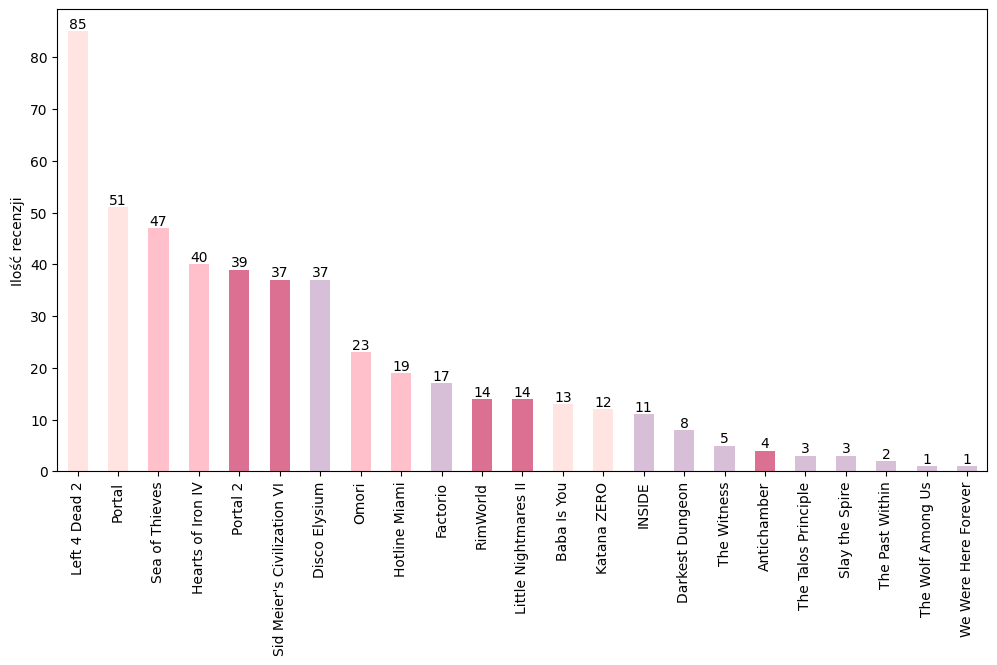

In [91]:
genre_colors = {"A": "mistyrose", "R": "palevioletred", "P": "thistle", "S": "pink"}
df['color'] = df['genre'].map(genre_colors)
colors = [df.loc[df['title'] == title]['color'].iloc[0] for title in value_counts_title.index]

plt.figure(figsize=(12, 6))
x = value_counts_hour_playtime.plot(kind = "bar", color = colors)
plt.ylabel("Ilość recenzji")
plt.xticks(rotation = 90)
for i, count in enumerate(value_counts_hour_playtime):
    x.text(i, count, count, va = "bottom", ha = "center")

plt.show()

In [92]:
df = df[df["playtime_at_review"]>1]

#### Długość recenzji

In [93]:
df["temp_review_len"] = df["review"].apply(lambda x: x.split(" ").__len__())
df["temp_review_len"].describe()

count    30613.000000
mean        49.558096
std        129.440064
min          1.000000
25%          4.000000
50%         11.000000
75%         35.000000
max       3997.000000
Name: temp_review_len, dtype: float64

In [94]:
df[df['temp_review_len'] < 4].groupby(by=['genre']).count()

,title,steamid,votes_up,review,weighted_vote_score,num_games_owned,playtime_at_review,num_reviews,timestamp_created,color,temp_review_len
genre,,,,,,,,,,,
A,2409,2409,2409,2409,2409,2409,2409,2409,2409,2409,2409
P,1245,1245,1245,1245,1245,1245,1245,1245,1245,1245,1245
R,1063,1063,1063,1063,1063,1063,1063,1063,1063,1063,1063
S,1752,1752,1752,1752,1752,1752,1752,1752,1752,1752,1752


In [95]:
df = df[df['temp_review_len'] > 4]

In [96]:
suma = 0
for i in df["temp_review_len"]:
    suma += i
print(suma)

1498469


In [97]:
print("Ilość słów:", suma,
     "Ilość recenzji:", len(df["temp_review_len"]))

Ilość słów: 1498469 Ilość recenzji: 22477
